In [46]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

#IMPORTING THE MODEL. ( IN MY CASE, I USE V6616 , YOU CAN ALSO USE RESNET OR OTHER)


In [47]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#LOCATION OF MY BASE DIRECTRY

In [48]:
BASE_DIR = '/content/drive/MyDrive/image_captioning/dataset'


In [49]:
from PIL import Image

features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)

    # Check if the file contains all the valid image cause many corrupted images may be present

    try:
        Image.open(img_path)
    except (IOError, OSError) as e:
        print(f"Skipping {img_path} - Unsupported or corrupted image file")
        continue

    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)


    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature


  0%|          | 0/8106 [00:00<?, ?it/s]

Skipping /content/drive/MyDrive/image_captioning/dataset/Images/train.txt - Unsupported or corrupted image file
Skipping /content/drive/MyDrive/image_captioning/dataset/Images/test.txt - Unsupported or corrupted image file


#READING THE CAPTIONS

In [50]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [51]:
# create mapping of image to captions
mappings = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]              # remove extension from image ID
    caption = " ".join(caption)
                                                   # convert caption list to string
    if image_id not in mappings:
        mappings[image_id] = []
    mappings[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [52]:
len(mappings)

8091

#BEFORE CLEANING

In [53]:
mappings['1220401002_3f44b1f3f7']

['Two children are laughing in the grass .',
 'Two girls laughing outside in a yard .',
 'Two girls standing on grass face each other .',
 'Two young girls are playing and laughing in a green grassy yard .',
 'Two young girls playing together .']

In [54]:
def clean(mappings):
    for key, captions in mappings.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end'
            captions[i] = caption

clean(mappings)

#AFTER CLEANING

In [55]:
mappings['1220401002_3f44b1f3f7']

['start two children are laughing in the grass end',
 'start two girls laughing outside in yard end',
 'start two girls standing on grass face each other end',
 'start two young girls are playing and laughing in green grassy yard end',
 'start two young girls playing together end']

In [56]:
all_captions = []
for key in mappings:
    for caption in mappings[key]:
        all_captions.append(caption)

In [57]:
len(all_captions)

40455

In [58]:
all_captions[:5]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [59]:
tokenizer = Tokenizer()                           # initializes a tokenizer object
tokenizer.fit_on_texts(all_captions)              # fits the Tokenizer on the text data
vocab_size = len(tokenizer.word_index) + 1        # calculates the vocabulary size

In [60]:
vocab_size

8483

In [61]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [62]:
image_ids = list(mappings.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [63]:
def data_generator(data_keys, mappings, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mappings[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

#MODEL ARCHITECTURE

In [64]:
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

In [65]:
decoder1 = add([fe2, se3])                                       # decoder model
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


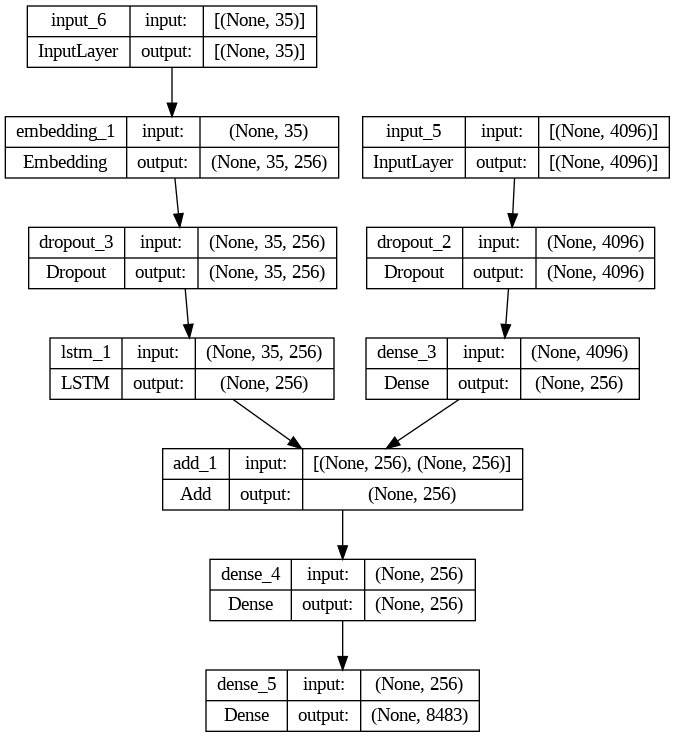

In [66]:
plot_model(model, show_shapes=True)                      # plot the model


In [69]:
# train the model
epochs = 3
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mappings, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs= 1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 1165s 5s/step - loss: 3.4002


In [70]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [71]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'end':
            break

    return in_text

In [85]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)  # predict the caption
    print('PREDICTED CAPTION------------->')
    print(y_pred)
    plt.imshow(image)


PREDICTED CAPTION------------->
start two dogs are walking on the beach end


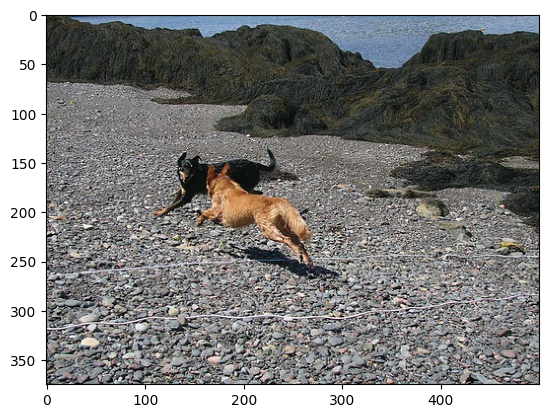

In [86]:
generate_caption("1056873310_49c665eb22.jpg")

PREDICTED CAPTION------------->
start black dog is running through the water end


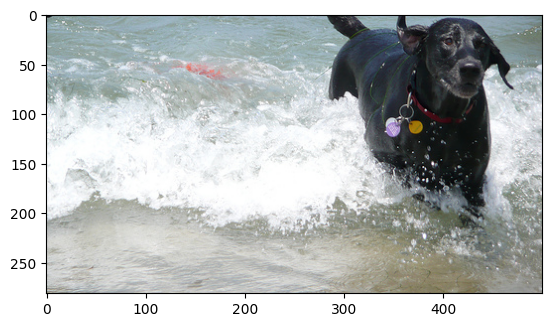

In [89]:
generate_caption('1022975728_75515238d8.jpg')